# Deep Learning - Assigment 1

### Group Number: 22

### Teammates:
1. **Mahshid Jafar Tajrishi**
2. **Bar Melinarskiy**
3. **Cis van Aken**
4. **Simon van Klompenburg**

## Imports entire notebook

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
from scipy.io import loadmat
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
torch.autograd.set_detect_anomaly(True)
from copy import deepcopy as dc
import random
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import json

## Global Definitions

In [2]:
# Path to the zip file
data_dir = "./Data"
data_path = f"{data_dir}/Xtrain.mat"

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)

# Set a professional style for the plots
sns.set_theme(style="whitegrid")

In [3]:
# Check if CUDA is available
print(torch.__version__)
print(torch.version.cuda)  # Should match CUDA 12.5
print(torch.backends.cudnn.version())  # Should return a version, not None
print(torch.cuda.is_available())  # Should return True

2.5.1
None
90100
True


### Utilities 

In [4]:
def create_sequences(data, window_size, forecast_steps=1):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_steps + 1):
        X.append(data[i:i + window_size, 0])
        y.append(data[i + window_size:i + window_size + forecast_steps, 0])
    X = np.array(X).reshape(-1, window_size, 1)
    y = np.array(y).reshape(-1, forecast_steps)
    return X, y

def prepare_dataloader(series, window_size, batch_size=16):
    """
    Preprocess the datasets for the transformer model.

    Args:
        series: Array of numbers with the sequence of the laser measurements.
        window_size: Integer, the sliding window size.
        batch_size: The number of samples used in one forward and backward pass through the network.

    Returns:
        DataLoader, X, y
    """
    X, y = create_sequences(series, window_size)
    # Ensure proper shapes: X → (N, seq_len, input_dim), y → (N, input_dim)
    X_tensor = torch.tensor(X, dtype=torch.float32)  # Shape: (N, seq_len, input_dim)
    y_tensor = torch.tensor(y, dtype=torch.float32)  # Shape: (N, input_dim)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False), X_tensor, y_tensor

def train_model(model, train_loader, val_loader, attempt_index, epochs=20, lr=1e-3, teacher_forcing_prob=0.5, patience=10):
    """
    Train the given model with validation and return the final validation L1 loss.
    Includes early stopping based on validation loss.
    Logs all metrics (L1, MSE, MAE) for each epoch into a DataFrame.
    """
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    # Define loss functions
    huberLoss_criterion = nn.HuberLoss()  # Huber Loss
    mse_criterion = nn.MSELoss()  # MSE Loss
    mae_criterion = nn.L1Loss()  # MAE Loss (same as L1 Loss)

    best_val_loss = float('inf')
    best_model_state = model.state_dict()  # Initialize with the current model state
    no_improvement_epochs = 0  # Counter for early stopping

    # DataFrame to store metrics
    metrics_df = pd.DataFrame(columns=["trial_id", "epoch", "train_l1", "train_mse", "train_mae", "val_l1", "val_mse", "val_mae"])

    # Progress bar for epochs
    epochs_pbar = tqdm(range(epochs), desc=f"Trial: {attempt_index}", unit="epoch")

    for epoch in epochs_pbar:
        # Training phase
        model.train()
        running_train_huberLoss_loss = 0.0
        running_train_mse_loss = 0.0
        running_train_mae_loss = 0.0

        for batch_index, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)

            # Forward pass
            output = model(x_batch)

            # Apply teacher forcing
            if random.random() < teacher_forcing_prob:
                x_batch = x_batch.clone()  # Avoid in-place modification
                x_batch[:, -1, 0] = y_batch[:, 0]

            # Calculate loss
            huberLoss_loss = huberLoss_criterion(output, y_batch)
            mse_loss = mse_criterion(output, y_batch)
            mae_loss = mae_criterion(output, y_batch)

            running_train_huberLoss_loss += huberLoss_loss.item()
            running_train_mse_loss += mse_loss.item()
            running_train_mae_loss += mae_loss.item()

            # Backward pass
            optimizer.zero_grad()
            mae_loss.backward()
            optimizer.step()

        avg_train_huberLoss_loss = running_train_huberLoss_loss / len(train_loader)
        avg_train_mse_loss = running_train_mse_loss / len(train_loader)
        avg_train_mae_loss = running_train_mae_loss / len(train_loader)

        # Validation phase
        model.eval()
        running_val_huberLoss_loss = 0.0
        running_val_mse_loss = 0.0
        running_val_mae_loss = 0.0

        with torch.no_grad():
            for batch in val_loader:
                x_batch, y_batch = batch[0].to(device), batch[1].to(device)
                output = model(x_batch)

                huberLoss_loss = huberLoss_criterion(output, y_batch)
                mse_loss = mse_criterion(output, y_batch)
                mae_loss = mae_criterion(output, y_batch)

                running_val_huberLoss_loss += huberLoss_loss.item()
                running_val_mse_loss += mse_loss.item()
                running_val_mae_loss += mae_loss.item()

        avg_val_huberLoss_loss = running_val_huberLoss_loss / len(val_loader)
        avg_val_mse_loss = running_val_mse_loss / len(val_loader)
        avg_val_mae_loss = running_val_mae_loss / len(val_loader)

        # Save metrics to DataFrame
        new_row = pd.DataFrame([{
            "trial_id": attempt_index,
            "epoch": epoch + 1,
            "train_HuberLoss": avg_train_huberLoss_loss,
            "train_MSE": avg_train_mse_loss,
            "train_MAE": avg_train_mae_loss,
            "val_HuberLoss": avg_val_huberLoss_loss,
            "val_MSE": avg_val_mse_loss,
            "val_MAE": avg_val_mae_loss
        }])
        metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

        # Save the best model
        if avg_val_huberLoss_loss < best_val_loss:
            best_val_loss = avg_val_huberLoss_loss
            best_model_state = model.state_dict()
            no_improvement_epochs = 0  # Reset early stopping counter
        else:
            no_improvement_epochs += 1  # Increment early stopping counter

        # Early stopping
        if no_improvement_epochs >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

        # Adjust learning rate
        scheduler.step()

        # Update progress bar
        epochs_pbar.set_postfix(
            Train_huberLoss_Loss=avg_train_huberLoss_loss,
            Train_MSE_Loss=avg_train_mse_loss,
            Train_MAE_Loss=avg_train_mae_loss,
            Val_huberLoss_Loss=avg_val_huberLoss_loss,
            Val_MSE_Loss=avg_val_mse_loss,
            Val_MAE_Loss=avg_val_mae_loss,
        )

    # Load the best model
    model.load_state_dict(best_model_state)

    return best_val_loss, metrics_df  # Return the best validation L1 loss and metrics DataFrame

### Long short-term memory (LSTM) RNN Model

In [5]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

### Load and Split the dataset into train-validation

In [6]:
data = loadmat(data_path)
measurements = data['Xtrain']
# Check the shape of the data
print("Shape of measurements:", measurements.shape)

# Display the first few rows of the data
print(f"First 5 measurements: {measurements[:5]}")

print(f"measurements range: min={measurements.min()}, max={measurements.max()}")

# Creating sequences
max_window_size = 50  # Maximum window size
# Split data into training and validation sets
size_of_test = 200 + max_window_size  # 200 steps for testing + window size
train_data, val_data = measurements[:-size_of_test], measurements[-size_of_test:]

# Normalize the training data
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data)

# Normalize the validation data using the same scaler
val_data_normalized = scaler.transform(val_data)

# Creating sequences
train_dataset, val_dataset = train_data_normalized, val_data_normalized

print(f"Train shape: {train_dataset.shape}, Val shape: {val_dataset.shape}")
print(f"train_dataset range: min={train_dataset.min()}, max={train_dataset.max()}")
print(f"val_dataset range: min={val_dataset.min()}, max={val_dataset.max()}")

Shape of measurements: (1000, 1)
First 5 measurements: [[ 86]
 [141]
 [ 95]
 [ 41]
 [ 22]]
measurements range: min=2, max=255
Train shape: (750, 1), Val shape: (250, 1)
train_dataset range: min=-0.9999999999999999, max=1.0
val_dataset range: min=-0.9209486166007904, max=0.3992094861660078


### Training the Model 

In [7]:
best_model = None

# Initialize a global DataFrame to store metrics for all trials
all_metrics_df = pd.DataFrame(columns=["trial_id", "epoch", "train_HuberLoss", "train_MSE", "train_MAE", "val_HuberLoss", "val_MSE", "val_MAE", 
                                       "hidden_size", "num_layers", "learning_rate", "batch_size", "window_size"])

def objective(trial):
    global all_metrics_df  # Use the global DataFrame to store metrics

    # Suggest hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 32, 256, step=32)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    window_size = trial.suggest_int('window_size', 5, 25, step=1)

    # Update data loaders with the suggested batch size
    train_loader, train_X, train_y = prepare_dataloader(train_dataset, window_size, batch_size=batch_size)
    val_loader, val_X, val_y = prepare_dataloader(val_dataset, window_size, batch_size=batch_size)

    # Define the model
    model = LSTM(
        input_size=1,  # Number of features in the input sequence
        hidden_size=hidden_size,
        num_stacked_layers=num_layers
    ).to(device)

    # Train the model and get the final validation loss and metrics DataFrame
    trial_index = trial.number + 1  # Start from 1 for better readability in logs
    val_loss, metrics_df = train_model(
        model, train_loader, val_loader, attempt_index=trial_index, epochs=100, lr=learning_rate
    )

    # Add trial parameters to the metrics DataFrame
    metrics_df["hidden_size"] = hidden_size
    metrics_df["num_layers"] = num_layers
    metrics_df["learning_rate"] = learning_rate
    metrics_df["batch_size"] = batch_size
    metrics_df["window_size"] = window_size

    # Save the best model
    if trial.number == 0 or val_loss < study.best_value:
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Best model saved with trial {trial.number}")
        best_model = model

        # Save the best hyperparameters
        with open("best_hyperparameters.json", "w") as f:
            json.dump({
                "hidden_size": hidden_size,
                "num_layers": num_layers,
                "learning_rate": learning_rate,
                "batch_size": batch_size,
                "window_size": window_size
            }, f)

    # Append the metrics for this trial to the global DataFrame
    all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

    return val_loss  # Optuna will minimize this


# Create a study object
study = optuna.create_study(direction="minimize")  # Minimize validation loss

# Optimize the objective function
study.optimize(objective, n_trials=100)  # Run 100 trials

# Save the combined metrics DataFrame to a CSV file
all_metrics_df.to_csv("all_trials_metrics.csv", index=False)
print("All metrics saved to all_trials_metrics.csv")

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)

# Print the best validation loss
print("Best validation loss:", study.best_value)

# Load the best model
best_model = LSTM(
    input_size=1,
    hidden_size=study.best_params['hidden_size'],
    num_stacked_layers=study.best_params['num_layers']
).to(device)
best_model.load_state_dict(torch.load("best_model.pth"))
print("Best model loaded.")

# Update train_loader and val_loader with the best hyperparameters
train_loader, train_X, train_y = prepare_dataloader(train_dataset, study.best_params['window_size'], batch_size=study.best_params['batch_size'])
val_loader, val_X, val_y = prepare_dataloader(val_dataset, study.best_params['window_size'], batch_size=study.best_params['batch_size'])
print("Data loaders updated with best hyperparameters.")

[I 2025-05-06 18:45:02,135] A new study created in memory with name: no-name-d8eafb0e-6b68-45f4-ace8-69b7ea78201a


Trial: 1:   0%|          | 0/100 [00:00<?, ?epoch/s]

C:\Users\bar24\AppData\Local\Temp\ipykernel_24820\289135419.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)
[I 2025-05-06 18:45:22,709] Trial 0 finished with value: 0.05845854710787535 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 1.2300414070413873e-05, 'batch_size': 32, 'window_size': 22}. Best is trial 0 with value: 0.05845854710787535.


Early stopping triggered after 68 epochs.
Best model saved with trial 0


Trial: 2:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:45:25,645] Trial 1 finished with value: 0.057378437370061874 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.0001466987043414333, 'batch_size': 128, 'window_size': 5}. Best is trial 1 with value: 0.057378437370061874.


Early stopping triggered after 23 epochs.
Best model saved with trial 1


Trial: 3:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:45:30,775] Trial 2 finished with value: 0.059661774430423975 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0001072434173713539, 'batch_size': 32, 'window_size': 23}. Best is trial 1 with value: 0.057378437370061874.


Early stopping triggered after 14 epochs.


Trial: 4:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:45:32,860] Trial 3 finished with value: 0.059642281383275986 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0011195575108692843, 'batch_size': 64, 'window_size': 12}. Best is trial 1 with value: 0.057378437370061874.


Early stopping triggered after 11 epochs.


Trial: 5:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:45:35,422] Trial 4 finished with value: 0.06592671666294336 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.00017492011399652878, 'batch_size': 64, 'window_size': 25}. Best is trial 1 with value: 0.057378437370061874.


Early stopping triggered after 16 epochs.


Trial: 6:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:45:43,325] Trial 5 finished with value: 0.057043748209252954 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.009632130427973031, 'batch_size': 32, 'window_size': 25}. Best is trial 5 with value: 0.057043748209252954.


Early stopping triggered after 18 epochs.
Best model saved with trial 5


Trial: 7:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:45:49,339] Trial 6 finished with value: 0.05867425724864006 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 2.440414291408141e-05, 'batch_size': 128, 'window_size': 16}. Best is trial 5 with value: 0.057043748209252954.


Early stopping triggered after 47 epochs.


Trial: 8:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:45:53,034] Trial 7 finished with value: 0.05924316216260195 and parameters: {'hidden_size': 96, 'num_layers': 1, 'lr': 0.0004999699284041361, 'batch_size': 32, 'window_size': 14}. Best is trial 5 with value: 0.057043748209252954.


Early stopping triggered after 13 epochs.


Trial: 9:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:45:57,879] Trial 8 finished with value: 0.05956214223988354 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 0.00011614703284346104, 'batch_size': 32, 'window_size': 10}. Best is trial 5 with value: 0.057043748209252954.


Early stopping triggered after 13 epochs.


Trial: 10:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:46:04,203] Trial 9 finished with value: 0.05851318780332804 and parameters: {'hidden_size': 160, 'num_layers': 3, 'lr': 3.083449087400127e-05, 'batch_size': 32, 'window_size': 14}. Best is trial 5 with value: 0.057043748209252954.


Early stopping triggered after 18 epochs.


Trial: 11:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:46:06,331] Trial 10 finished with value: 0.06190877500921488 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 0.009703852166450215, 'batch_size': 64, 'window_size': 20}. Best is trial 5 with value: 0.057043748209252954.


Early stopping triggered after 13 epochs.


Trial: 12:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:46:08,793] Trial 11 finished with value: 0.004215153167024255 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.009738978348914415, 'batch_size': 128, 'window_size': 5}. Best is trial 11 with value: 0.004215153167024255.


Early stopping triggered after 22 epochs.
Best model saved with trial 11


Trial: 13:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:46:13,697] Trial 12 finished with value: 0.0009511735115665942 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 0.008941674482212949, 'batch_size': 128, 'window_size': 6}. Best is trial 12 with value: 0.0009511735115665942.


Early stopping triggered after 44 epochs.
Best model saved with trial 12


Trial: 14:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:46:18,190] Trial 13 finished with value: 0.002310157520696521 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 0.0033501295863104658, 'batch_size': 128, 'window_size': 5}. Best is trial 12 with value: 0.0009511735115665942.


Early stopping triggered after 38 epochs.


Trial: 15:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:46:24,441] Trial 14 finished with value: 0.00017761295021045953 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.002145810182583391, 'batch_size': 128, 'window_size': 8}. Best is trial 14 with value: 0.00017761295021045953.


Early stopping triggered after 57 epochs.
Best model saved with trial 14


Trial: 16:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:46:29,202] Trial 15 finished with value: 0.0012179124751128256 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.001430218091633708, 'batch_size': 128, 'window_size': 9}. Best is trial 14 with value: 0.00017761295021045953.


Early stopping triggered after 43 epochs.


Trial: 17:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:46:30,526] Trial 16 finished with value: 0.056309789419174194 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.002884988095347731, 'batch_size': 128, 'window_size': 8}. Best is trial 14 with value: 0.00017761295021045953.


Early stopping triggered after 13 epochs.


Trial: 18:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:46:35,172] Trial 17 finished with value: 0.00025405798805877566 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0036475374459166376, 'batch_size': 128, 'window_size': 8}. Best is trial 14 with value: 0.00017761295021045953.


Early stopping triggered after 44 epochs.


Trial: 19:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:46:37,081] Trial 18 finished with value: 0.06016789190471172 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0006180926590184768, 'batch_size': 128, 'window_size': 17}. Best is trial 14 with value: 0.00017761295021045953.


Early stopping triggered after 15 epochs.


Trial: 20:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:46:41,729] Trial 19 finished with value: 0.000901449122466147 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0031260391932167913, 'batch_size': 128, 'window_size': 11}. Best is trial 14 with value: 0.00017761295021045953.


Early stopping triggered after 43 epochs.


Trial: 21:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:46:43,383] Trial 20 finished with value: 0.05634624697268009 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.0015680935709074502, 'batch_size': 128, 'window_size': 8}. Best is trial 14 with value: 0.00017761295021045953.


Early stopping triggered after 17 epochs.


Trial: 22:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:46:48,301] Trial 21 finished with value: 0.000217646942473948 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.003927004535298236, 'batch_size': 128, 'window_size': 12}. Best is trial 14 with value: 0.00017761295021045953.


Early stopping triggered after 44 epochs.


Trial: 23:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:46:53,628] Trial 22 finished with value: 0.00023987314489204437 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.004483918816802455, 'batch_size': 128, 'window_size': 12}. Best is trial 14 with value: 0.00017761295021045953.


Early stopping triggered after 43 epochs.


Trial: 24:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:46:55,680] Trial 23 finished with value: 0.05953279882669449 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.004856899906177209, 'batch_size': 128, 'window_size': 12}. Best is trial 14 with value: 0.00017761295021045953.


Early stopping triggered after 16 epochs.


Trial: 25:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:46:57,599] Trial 24 finished with value: 0.06353052891790867 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.001925601198123657, 'batch_size': 128, 'window_size': 18}. Best is trial 14 with value: 0.00017761295021045953.


Early stopping triggered after 14 epochs.


Trial: 26:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:47:00,208] Trial 25 finished with value: 0.05750749632716179 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0009346291438969511, 'batch_size': 64, 'window_size': 13}. Best is trial 14 with value: 0.00017761295021045953.


Early stopping triggered after 14 epochs.


Trial: 27:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:47:01,700] Trial 26 finished with value: 0.055055368691682816 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.005427602002507721, 'batch_size': 128, 'window_size': 10}. Best is trial 14 with value: 0.00017761295021045953.


Early stopping triggered after 15 epochs.


Trial: 28:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:47:03,421] Trial 27 finished with value: 0.05882745608687401 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.0005019515598366701, 'batch_size': 128, 'window_size': 15}. Best is trial 14 with value: 0.00017761295021045953.


Early stopping triggered after 14 epochs.


Trial: 29:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:47:07,758] Trial 28 finished with value: 0.001225010899361223 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0019040695790368655, 'batch_size': 128, 'window_size': 7}. Best is trial 14 with value: 0.00017761295021045953.


Early stopping triggered after 37 epochs.


Trial: 30:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:47:10,181] Trial 29 finished with value: 0.05867477413266897 and parameters: {'hidden_size': 96, 'num_layers': 1, 'lr': 0.00024047592405712366, 'batch_size': 64, 'window_size': 11}. Best is trial 14 with value: 0.00017761295021045953.


Early stopping triggered after 15 epochs.


Trial: 31:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:47:14,124] Trial 30 finished with value: 0.00014844722318230197 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.005104479459656995, 'batch_size': 128, 'window_size': 13}. Best is trial 30 with value: 0.00014844722318230197.


Early stopping triggered after 40 epochs.
Best model saved with trial 30


Trial: 32:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:47:15,551] Trial 31 finished with value: 0.05764646455645561 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.005633261513733992, 'batch_size': 128, 'window_size': 13}. Best is trial 30 with value: 0.00014844722318230197.


Early stopping triggered after 14 epochs.


Trial: 33:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:47:20,582] Trial 32 finished with value: 0.0003544373903423548 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0056280476856183205, 'batch_size': 128, 'window_size': 10}. Best is trial 30 with value: 0.00014844722318230197.


Early stopping triggered after 44 epochs.


Trial: 34:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:47:21,930] Trial 33 finished with value: 0.059305403381586075 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 0.0025487871558210503, 'batch_size': 128, 'window_size': 14}. Best is trial 30 with value: 0.00014844722318230197.


Early stopping triggered after 14 epochs.


Trial: 35:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:47:23,442] Trial 34 finished with value: 0.06060686334967613 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.0010366577868318682, 'batch_size': 128, 'window_size': 19}. Best is trial 30 with value: 0.00014844722318230197.


Early stopping triggered after 14 epochs.


Trial: 36:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:47:27,446] Trial 35 finished with value: 0.00030710675491718575 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.004408696662508659, 'batch_size': 128, 'window_size': 12}. Best is trial 30 with value: 0.00014844722318230197.


Early stopping triggered after 40 epochs.


Trial: 37:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:47:29,202] Trial 36 finished with value: 0.05866533704102039 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.006660706949894341, 'batch_size': 128, 'window_size': 16}. Best is trial 30 with value: 0.00014844722318230197.


Early stopping triggered after 13 epochs.


Trial: 38:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:47:36,655] Trial 37 finished with value: 0.0003697474421642255 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.002205100660908189, 'batch_size': 64, 'window_size': 11}. Best is trial 30 with value: 0.00014844722318230197.


Early stopping triggered after 39 epochs.


Trial: 39:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:47:49,803] Trial 38 finished with value: 0.0015116359791136347 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.0006847654748256612, 'batch_size': 32, 'window_size': 15}. Best is trial 30 with value: 0.00014844722318230197.


Early stopping triggered after 42 epochs.


Trial: 40:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:47:51,825] Trial 39 finished with value: 0.06058490462601185 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.00035249563436586136, 'batch_size': 128, 'window_size': 22}. Best is trial 30 with value: 0.00014844722318230197.


Early stopping triggered after 16 epochs.


Trial: 41:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:47:58,428] Trial 40 finished with value: 0.001075352935004048 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.0073026218968421305, 'batch_size': 32, 'window_size': 9}. Best is trial 30 with value: 0.00014844722318230197.


Early stopping triggered after 22 epochs.


Trial: 42:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:48:02,983] Trial 41 finished with value: 0.0003615318419178948 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.003744005587314386, 'batch_size': 128, 'window_size': 7}. Best is trial 30 with value: 0.00014844722318230197.


Early stopping triggered after 42 epochs.


Trial: 43:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:48:08,383] Trial 42 finished with value: 0.00031406720518134534 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.004025744666915054, 'batch_size': 128, 'window_size': 9}. Best is trial 30 with value: 0.00014844722318230197.


Early stopping triggered after 43 epochs.


Trial: 44:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:48:11,703] Trial 43 finished with value: 0.05876626819372177 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 5.9402113997495374e-05, 'batch_size': 128, 'window_size': 13}. Best is trial 30 with value: 0.00014844722318230197.


Early stopping triggered after 30 epochs.


Trial: 45:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:48:15,820] Trial 44 finished with value: 0.0009956423018593341 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.002595981695779642, 'batch_size': 128, 'window_size': 7}. Best is trial 30 with value: 0.00014844722318230197.


Early stopping triggered after 40 epochs.


Trial: 46:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:48:17,202] Trial 45 finished with value: 0.056943099945783615 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 0.001482501734440584, 'batch_size': 128, 'window_size': 8}. Best is trial 30 with value: 0.00014844722318230197.


Early stopping triggered after 11 epochs.


Trial: 47:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:48:24,865] Trial 46 finished with value: 0.0005980776513752062 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 0.007155686780120683, 'batch_size': 32, 'window_size': 12}. Best is trial 30 with value: 0.00014844722318230197.


Early stopping triggered after 22 epochs.


Trial: 48:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:48:38,737] Trial 47 finished with value: 0.05857544718310237 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 1.2583335810341099e-05, 'batch_size': 64, 'window_size': 6}. Best is trial 30 with value: 0.00014844722318230197.


Early stopping triggered after 69 epochs.


Trial: 49:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:48:40,653] Trial 48 finished with value: 0.05719682201743126 and parameters: {'hidden_size': 160, 'num_layers': 3, 'lr': 0.0036044557074449454, 'batch_size': 128, 'window_size': 10}. Best is trial 30 with value: 0.00014844722318230197.


Early stopping triggered after 14 epochs.


Trial: 50:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:48:42,251] Trial 49 finished with value: 0.05809184908866882 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0012316421439158235, 'batch_size': 128, 'window_size': 15}. Best is trial 30 with value: 0.00014844722318230197.


Early stopping triggered after 14 epochs.


Trial: 51:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:48:43,755] Trial 50 finished with value: 0.05509229749441147 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.0007780041077688561, 'batch_size': 128, 'window_size': 6}. Best is trial 30 with value: 0.00014844722318230197.


Early stopping triggered after 14 epochs.


Trial: 52:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:48:49,350] Trial 51 finished with value: 0.00029053301841486245 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 0.004716688902971401, 'batch_size': 128, 'window_size': 12}. Best is trial 30 with value: 0.00014844722318230197.


Early stopping triggered after 60 epochs.


Trial: 53:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:48:53,320] Trial 52 finished with value: 0.0002473101994837634 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 0.007257309743076657, 'batch_size': 128, 'window_size': 11}. Best is trial 30 with value: 0.00014844722318230197.


Early stopping triggered after 43 epochs.


Trial: 54:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:48:54,486] Trial 53 finished with value: 0.05576969310641289 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.008940958787767623, 'batch_size': 128, 'window_size': 11}. Best is trial 30 with value: 0.00014844722318230197.


Early stopping triggered after 12 epochs.


Trial: 55:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:48:56,994] Trial 54 finished with value: 0.05928392522037029 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.007259077175917172, 'batch_size': 128, 'window_size': 9}. Best is trial 30 with value: 0.00014844722318230197.


Early stopping triggered after 15 epochs.


Trial: 56:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:49:02,826] Trial 55 finished with value: 0.00024456370738334954 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 0.002748825972025892, 'batch_size': 128, 'window_size': 14}. Best is trial 30 with value: 0.00014844722318230197.


Early stopping triggered after 63 epochs.


Trial: 57:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:49:04,296] Trial 56 finished with value: 0.05520866625010967 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.002035855496669208, 'batch_size': 128, 'window_size': 14}. Best is trial 30 with value: 0.00014844722318230197.


Early stopping triggered after 15 epochs.


Trial: 58:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:49:11,027] Trial 57 finished with value: 0.003918866161257029 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 0.0028149778577032407, 'batch_size': 32, 'window_size': 16}. Best is trial 30 with value: 0.00014844722318230197.


Early stopping triggered after 22 epochs.


Trial: 59:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:49:15,128] Trial 58 finished with value: 0.00043394588283263147 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.00598273819378752, 'batch_size': 128, 'window_size': 13}. Best is trial 30 with value: 0.00014844722318230197.


Early stopping triggered after 44 epochs.


Trial: 60:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:49:22,173] Trial 59 finished with value: 0.0002251307014375925 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.009569770892098168, 'batch_size': 64, 'window_size': 13}. Best is trial 30 with value: 0.00014844722318230197.


Early stopping triggered after 40 epochs.


Trial: 61:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:49:29,249] Trial 60 finished with value: 0.00010693312651710585 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.009697983509477783, 'batch_size': 64, 'window_size': 17}. Best is trial 60 with value: 0.00010693312651710585.


Early stopping triggered after 40 epochs.
Best model saved with trial 60


Trial: 62:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:49:36,045] Trial 61 finished with value: 0.00018633994113770314 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.009996244589265874, 'batch_size': 64, 'window_size': 17}. Best is trial 60 with value: 0.00010693312651710585.


Early stopping triggered after 40 epochs.


Trial: 63:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:49:42,778] Trial 62 finished with value: 0.00020237395801814273 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.0091535072276068, 'batch_size': 64, 'window_size': 18}. Best is trial 60 with value: 0.00010693312651710585.


Early stopping triggered after 40 epochs.


Trial: 64:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:49:50,116] Trial 63 finished with value: 0.00021072858362458646 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.009819917082038755, 'batch_size': 64, 'window_size': 18}. Best is trial 60 with value: 0.00010693312651710585.


Early stopping triggered after 40 epochs.


Trial: 65:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:49:57,999] Trial 64 finished with value: 0.00018899866699939594 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.008876054989249673, 'batch_size': 64, 'window_size': 20}. Best is trial 60 with value: 0.00010693312651710585.


Early stopping triggered after 42 epochs.


Trial: 66:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:50:05,798] Trial 65 finished with value: 0.00012117850019421894 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.008485094959962905, 'batch_size': 64, 'window_size': 21}. Best is trial 60 with value: 0.00010693312651710585.


Early stopping triggered after 42 epochs.


Trial: 67:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:50:12,846] Trial 66 finished with value: 0.00033603211340960115 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.00806528790227097, 'batch_size': 64, 'window_size': 21}. Best is trial 60 with value: 0.00010693312651710585.


Early stopping triggered after 39 epochs.


Trial: 68:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:50:19,552] Trial 67 finished with value: 0.00017184135867864825 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.005748673693606297, 'batch_size': 64, 'window_size': 20}. Best is trial 60 with value: 0.00010693312651710585.


Early stopping triggered after 42 epochs.


Trial: 69:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:50:26,323] Trial 68 finished with value: 0.0003521251092024613 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.00585135537339374, 'batch_size': 64, 'window_size': 24}. Best is trial 60 with value: 0.00010693312651710585.


Early stopping triggered after 42 epochs.


Trial: 70:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:50:32,534] Trial 69 finished with value: 0.0001353239786112681 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.00498829861048657, 'batch_size': 64, 'window_size': 20}. Best is trial 60 with value: 0.00010693312651710585.


Early stopping triggered after 39 epochs.


Trial: 71:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:50:39,359] Trial 70 finished with value: 0.00027428738394519314 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.004733847298045252, 'batch_size': 64, 'window_size': 20}. Best is trial 60 with value: 0.00010693312651710585.


Early stopping triggered after 43 epochs.


Trial: 72:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:50:49,323] Trial 71 finished with value: 7.975271000759676e-05 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.005930188434810732, 'batch_size': 64, 'window_size': 20}. Best is trial 71 with value: 7.975271000759676e-05.


Early stopping triggered after 62 epochs.
Best model saved with trial 71


Trial: 73:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:50:56,263] Trial 72 finished with value: 0.0005043310302426107 and parameters: {'hidden_size': 96, 'num_layers': 1, 'lr': 0.005879830640965983, 'batch_size': 64, 'window_size': 22}. Best is trial 71 with value: 7.975271000759676e-05.


Early stopping triggered after 43 epochs.


Trial: 74:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:51:05,744] Trial 73 finished with value: 0.00019180179151589982 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.003449206742662366, 'batch_size': 64, 'window_size': 19}. Best is trial 71 with value: 7.975271000759676e-05.


Early stopping triggered after 62 epochs.


Trial: 75:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:51:12,458] Trial 74 finished with value: 0.0006704654588247649 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.005176895962075358, 'batch_size': 64, 'window_size': 17}. Best is trial 71 with value: 7.975271000759676e-05.


Early stopping triggered after 43 epochs.


Trial: 76:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:51:15,922] Trial 75 finished with value: 0.0019299642299301922 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.007745510346394485, 'batch_size': 64, 'window_size': 21}. Best is trial 71 with value: 7.975271000759676e-05.


Early stopping triggered after 22 epochs.


Trial: 77:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:51:25,317] Trial 76 finished with value: 0.00010183780432271305 and parameters: {'hidden_size': 96, 'num_layers': 1, 'lr': 0.006413141619474543, 'batch_size': 64, 'window_size': 21}. Best is trial 71 with value: 7.975271000759676e-05.


Early stopping triggered after 60 epochs.


Trial: 78:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:51:32,032] Trial 77 finished with value: 0.00047579500096617267 and parameters: {'hidden_size': 96, 'num_layers': 1, 'lr': 0.004532833808013227, 'batch_size': 64, 'window_size': 23}. Best is trial 71 with value: 7.975271000759676e-05.


Early stopping triggered after 44 epochs.


Trial: 79:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:51:39,110] Trial 78 finished with value: 0.00021983190163155086 and parameters: {'hidden_size': 96, 'num_layers': 1, 'lr': 0.006491657287135416, 'batch_size': 64, 'window_size': 21}. Best is trial 71 with value: 7.975271000759676e-05.


Early stopping triggered after 45 epochs.


Trial: 80:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:51:48,596] Trial 79 finished with value: 0.0004621904081432149 and parameters: {'hidden_size': 64, 'num_layers': 1, 'lr': 0.0031972115439526253, 'batch_size': 64, 'window_size': 19}. Best is trial 71 with value: 7.975271000759676e-05.


Early stopping triggered after 60 epochs.


Trial: 81:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:51:55,369] Trial 80 finished with value: 0.0025645394052844495 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.0017017214140069086, 'batch_size': 64, 'window_size': 20}. Best is trial 71 with value: 7.975271000759676e-05.


Early stopping triggered after 43 epochs.


Trial: 82:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:52:02,111] Trial 81 finished with value: 0.00029699690276174806 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.006378031125944376, 'batch_size': 64, 'window_size': 17}. Best is trial 71 with value: 7.975271000759676e-05.


Early stopping triggered after 42 epochs.


Trial: 83:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:52:11,752] Trial 82 finished with value: 0.00017994825066125486 and parameters: {'hidden_size': 96, 'num_layers': 1, 'lr': 0.003954632452477743, 'batch_size': 64, 'window_size': 23}. Best is trial 71 with value: 7.975271000759676e-05.


Early stopping triggered after 62 epochs.


Trial: 84:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:52:18,633] Trial 83 finished with value: 0.0009319394157500938 and parameters: {'hidden_size': 64, 'num_layers': 1, 'lr': 0.005301684616793517, 'batch_size': 64, 'window_size': 24}. Best is trial 71 with value: 7.975271000759676e-05.


Early stopping triggered after 44 epochs.


Trial: 85:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:52:20,834] Trial 84 finished with value: 0.06111500132828951 and parameters: {'hidden_size': 32, 'num_layers': 1, 'lr': 0.002275968332371408, 'batch_size': 64, 'window_size': 23}. Best is trial 71 with value: 7.975271000759676e-05.


Early stopping triggered after 13 epochs.


Trial: 86:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:52:27,709] Trial 85 finished with value: 0.0010849252830666956 and parameters: {'hidden_size': 96, 'num_layers': 1, 'lr': 0.004047511843051711, 'batch_size': 64, 'window_size': 21}. Best is trial 71 with value: 7.975271000759676e-05.


Early stopping triggered after 39 epochs.


Trial: 87:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:52:35,163] Trial 86 finished with value: 0.0004082365812791977 and parameters: {'hidden_size': 96, 'num_layers': 1, 'lr': 0.004245396994285667, 'batch_size': 64, 'window_size': 23}. Best is trial 71 with value: 7.975271000759676e-05.


Early stopping triggered after 43 epochs.


Trial: 88:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:52:40,283] Trial 87 finished with value: 0.06374624790623784 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 7.293904163027495e-05, 'batch_size': 64, 'window_size': 22}. Best is trial 71 with value: 7.975271000759676e-05.


Early stopping triggered after 32 epochs.


Trial: 89:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:52:42,350] Trial 88 finished with value: 0.059860751032829285 and parameters: {'hidden_size': 64, 'num_layers': 1, 'lr': 0.0032544915701958116, 'batch_size': 64, 'window_size': 19}. Best is trial 71 with value: 7.975271000759676e-05.


Early stopping triggered after 13 epochs.


Trial: 90:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:52:49,192] Trial 89 finished with value: 0.00020701741595985368 and parameters: {'hidden_size': 96, 'num_layers': 1, 'lr': 0.008053732781111583, 'batch_size': 64, 'window_size': 25}. Best is trial 71 with value: 7.975271000759676e-05.


Early stopping triggered after 42 epochs.


Trial: 91:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:52:59,437] Trial 90 finished with value: 0.00011759236258512828 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.0051585602338662835, 'batch_size': 64, 'window_size': 22}. Best is trial 71 with value: 7.975271000759676e-05.


Early stopping triggered after 59 epochs.


Trial: 92:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:53:06,437] Trial 91 finished with value: 0.00016199050878640264 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.005085814524945144, 'batch_size': 64, 'window_size': 22}. Best is trial 71 with value: 7.975271000759676e-05.


Early stopping triggered after 42 epochs.


Trial: 93:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:53:13,170] Trial 92 finished with value: 0.00025428149456274696 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.006419632898661607, 'batch_size': 64, 'window_size': 22}. Best is trial 71 with value: 7.975271000759676e-05.


Early stopping triggered after 38 epochs.


Trial: 94:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:53:20,093] Trial 93 finished with value: 0.0005041137337684631 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.005217649347546501, 'batch_size': 64, 'window_size': 20}. Best is trial 71 with value: 7.975271000759676e-05.


Early stopping triggered after 43 epochs.


Trial: 95:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:53:23,117] Trial 94 finished with value: 0.0030472731741610914 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.007725154505619983, 'batch_size': 64, 'window_size': 21}. Best is trial 71 with value: 7.975271000759676e-05.


Early stopping triggered after 19 epochs.


Trial: 96:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:53:29,397] Trial 95 finished with value: 0.0006663165404461324 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.004817836485324673, 'batch_size': 64, 'window_size': 20}. Best is trial 71 with value: 7.975271000759676e-05.


Early stopping triggered after 37 epochs.


Trial: 97:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:53:37,424] Trial 96 finished with value: 0.0018807315354933962 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.002356326519828125, 'batch_size': 64, 'window_size': 19}. Best is trial 71 with value: 7.975271000759676e-05.


Early stopping triggered after 44 epochs.


Trial: 98:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:53:41,376] Trial 97 finished with value: 0.06335046328604221 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.00017741936681431696, 'batch_size': 32, 'window_size': 18}. Best is trial 71 with value: 7.975271000759676e-05.


Early stopping triggered after 14 epochs.


Trial: 99:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:53:48,832] Trial 98 finished with value: 0.0019293622754048556 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.0029966869502522585, 'batch_size': 64, 'window_size': 21}. Best is trial 71 with value: 7.975271000759676e-05.


Early stopping triggered after 43 epochs.


Trial: 100:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-06 18:53:58,675] Trial 99 finished with value: 8.745272862142883e-05 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.006918095863712325, 'batch_size': 64, 'window_size': 22}. Best is trial 71 with value: 7.975271000759676e-05.


Early stopping triggered after 60 epochs.
All metrics saved to all_trials_metrics.csv
Best hyperparameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.005930188434810732, 'batch_size': 64, 'window_size': 20}
Best validation loss: 7.975271000759676e-05
Best model loaded.
Data loaders updated with best hyperparameters.


C:\Users\bar24\AppData\Local\Temp\ipykernel_24820\289135419.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("best_model.pth"))


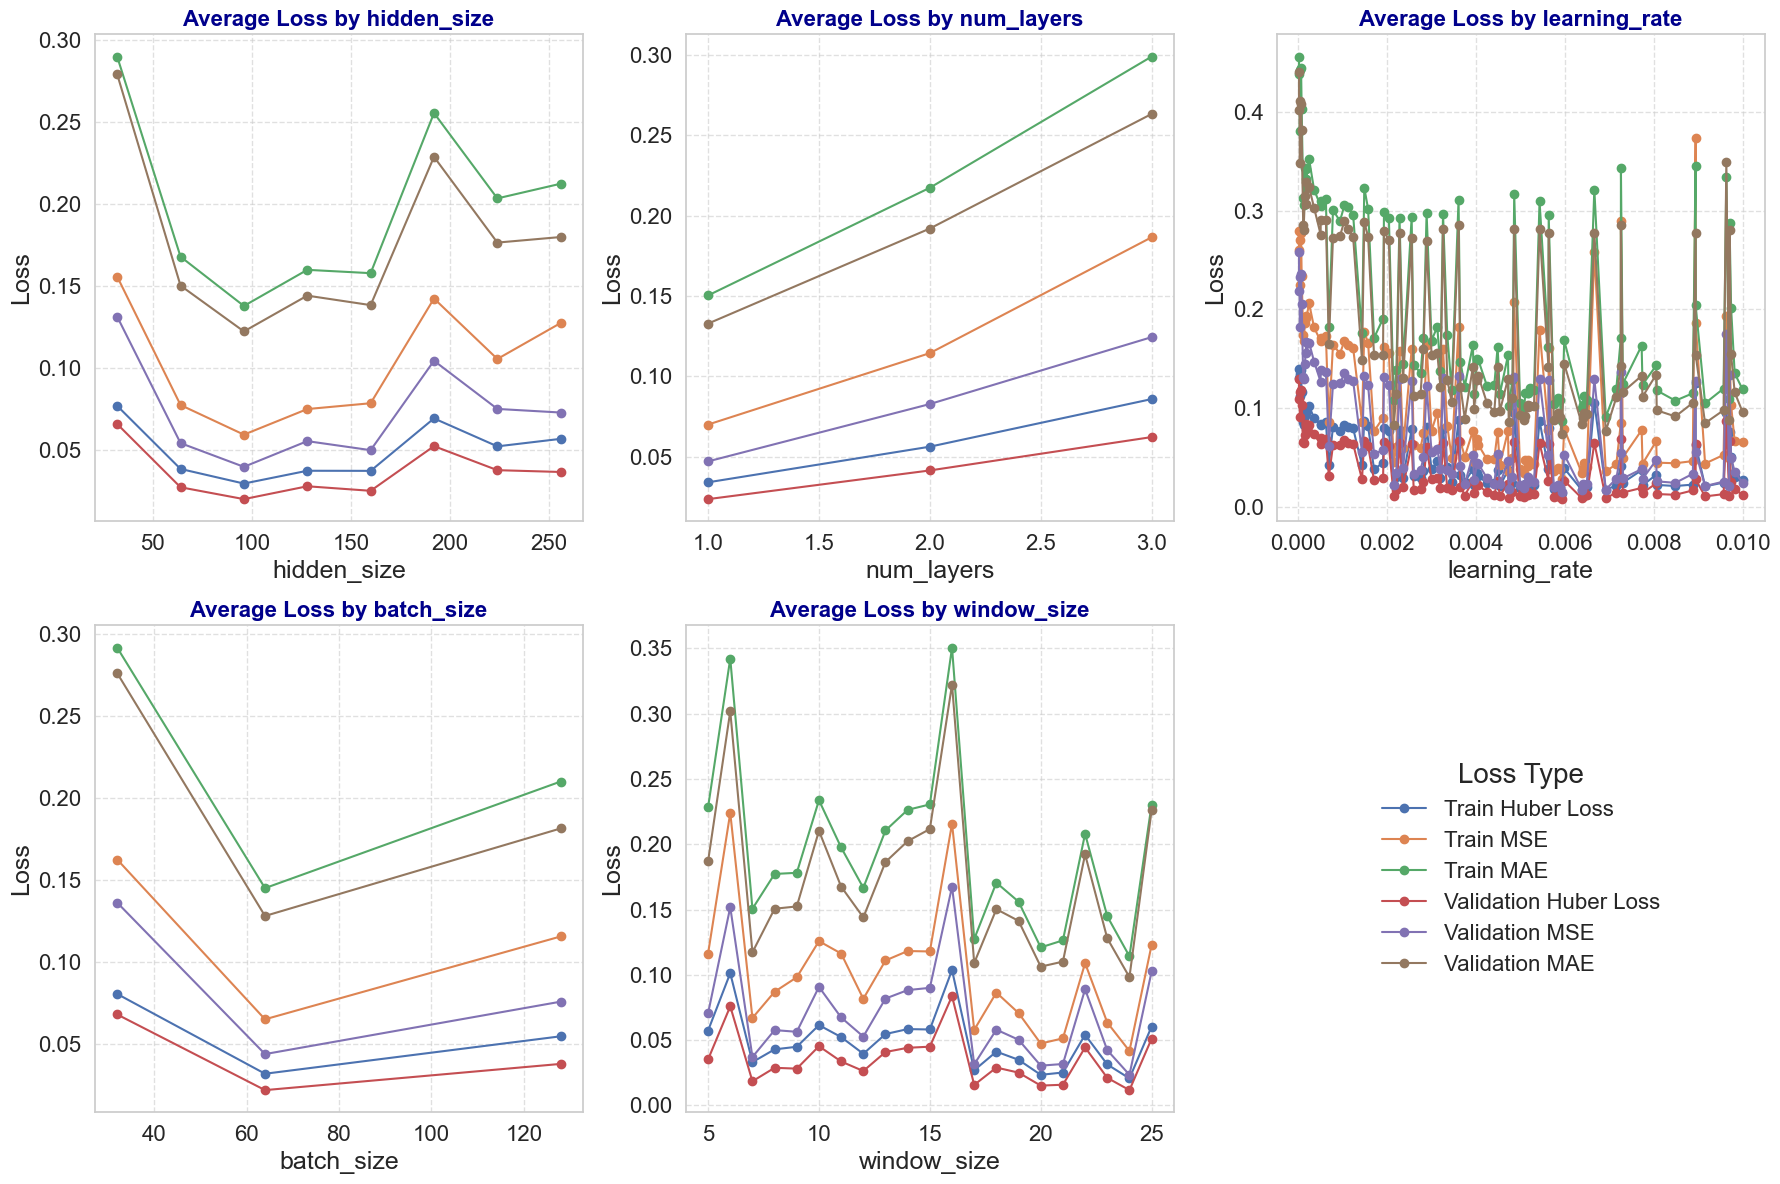

In [8]:
def plot_metrics_by_parameters(metrics_df, parameters, save_path="metrics_by_parameters.png"):
    """
    Create a single figure with subplots for each parameter, showing average losses.

    Args:
        metrics_df (pd.DataFrame): DataFrame containing trial metrics and parameters.
        parameters (list): List of parameters to plot (e.g., ['hidden_size', 'num_layers']).
    """
    # Mapping loss types to more readable names
    loss_type_mapping = {
        "train_HuberLoss": "Train Huber Loss",
        "train_MSE": "Train MSE",
        "train_MAE": "Train MAE",
        "val_HuberLoss": "Validation Huber Loss",
        "val_MSE": "Validation MSE",
        "val_MAE": "Validation MAE"
    }

    num_params = len(parameters)
    ncols = 3  # Number of columns
    nrows = 2  # Fixed to 2 rows
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 12), sharex=False)

    # Flatten axes for easier iteration
    axes = axes.flatten()

    # Plot each parameter
    for i, (ax, parameter) in enumerate(zip(axes, parameters)):
        grouped = metrics_df.groupby(parameter).mean()  # Group by the parameter and calculate averages
        for loss, readable_name in loss_type_mapping.items():
            if loss in grouped.columns:
                ax.plot(grouped.index, grouped[loss], label=readable_name, marker='o', linestyle='-', linewidth=1.5)

        # Customize each subplot
        ax.set_xlabel(parameter, fontsize=18)
        ax.set_ylabel("Loss", fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.set_title(f"Average Loss by {parameter}", fontsize=16, weight='bold', color='darkblue')
        ax.grid(True, linestyle='--', alpha=0.6)

    # Remove unused subplots if parameters < nrows * ncols
    for j in range(len(parameters), len(axes)):
        if j == len(parameters):  # Use the first unused subplot for the legend
            handles, labels = ax.get_legend_handles_labels()
            axes[j].legend(
                handles, labels, loc="center", fontsize=16, title="Loss Type", title_fontsize=20, frameon=False
            )
            axes[j].set_axis_off()  # Turn off the axis for the legend plot
        else:
            fig.delaxes(axes[j])  # Remove any additional unused subplots

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

# Example: Plot average losses for all parameters in one figure
parameters_to_plot = ["hidden_size", "num_layers", "learning_rate", "batch_size", "window_size"]
plot_metrics_by_parameters(all_metrics_df, parameters_to_plot)

### Predict the next 200 data points recursively

C:\Users\bar24\AppData\Local\Temp\ipykernel_24820\189218032.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  init_window = torch.tensor(val_X[0], dtype=torch.float32).to(device)  # Use the first sequence as the initial window


first 10 predictions: [-0.20676852762699127, -0.4659101366996765, -0.7401496171951294, -0.841995894908905, -0.817428469657898, -0.6281605958938599, -0.22647306323051453, -0.10181839019060135, -0.5296445488929749, -0.8290432691574097]


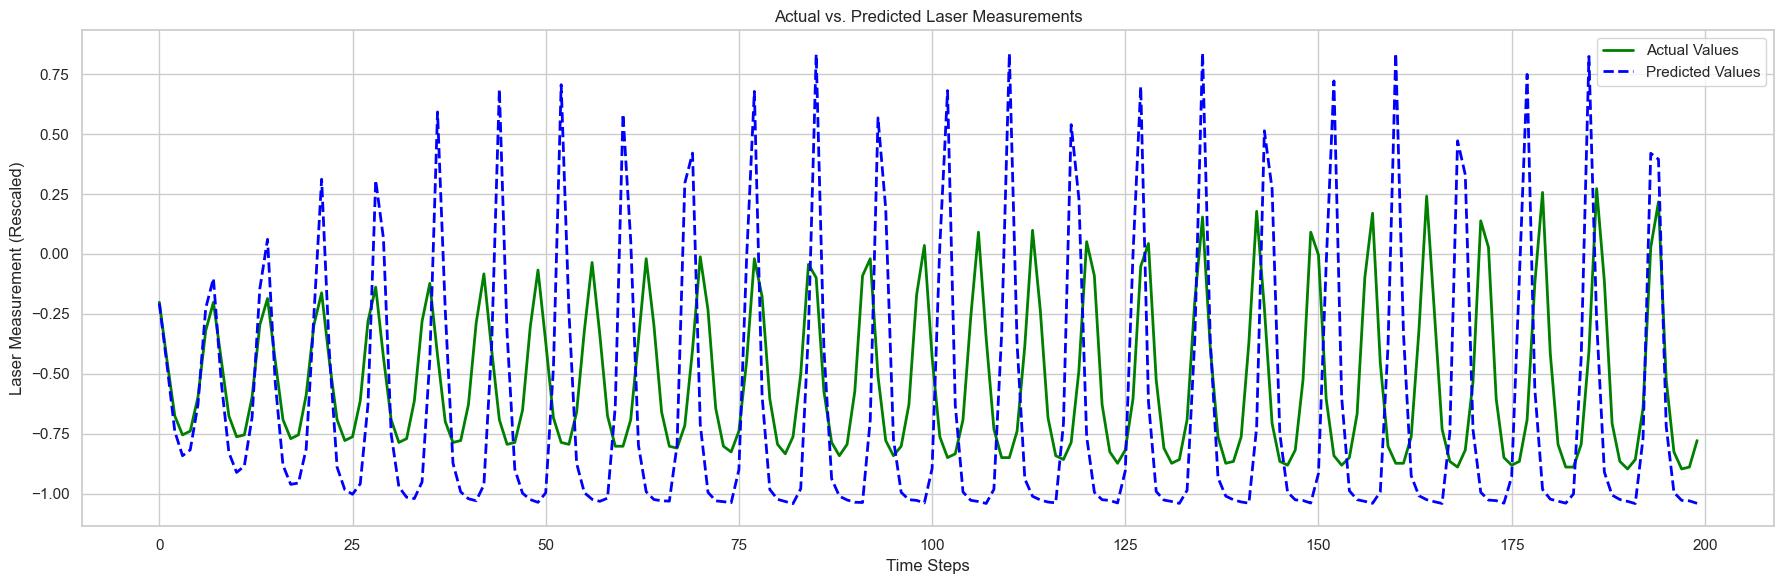

Metrics plot saved to actual_vs_predicted_plot.png


In [9]:
def recursive_forecast(model, init_window, steps=200):
    """
    Perform recursive forecasting using the trained model.

    Args:
        model: The trained Transformer model.
        init_window: The initial sequence window (tensor).
        steps: Number of forecasting steps.
        std: Standard deviation used for normalization.
        mean: Mean used for normalization.

    Returns:
        np.array: Forecasted values rescaled to the original range.
    """
    model.eval()
    preds = []
    current_seq = init_window.clone().to(device)  # Ensure the initial window is on the correct device

    with torch.no_grad():
        for step in range(steps):
            # Forward pass
            input = current_seq.unsqueeze(0).contiguous()  # Add batch dimension
            pred = model(input)  # shape: (1, seq_len, forecast_steps)

            # Extract the first predicted value
            pred_value = pred.item()  # Extract the first step of the forecast
            # Append the prediction
            preds.append(pred_value)

            next_value = torch.tensor([[pred_value]], dtype=torch.float32,  device=device)  # Convert to tensor for concatenation

            # Update the sequence by appending the prediction and removing the oldest value
            current_seq = torch.cat((current_seq[1:], next_value), dim=0)  # Update the sequence
            # # Optional: Clamp predictions to avoid divergence
            # current_seq = torch.clamp(current_seq, min=-3, max=3)  # Adjust range based on normalized data

    print(f"first 10 predictions: {preds[:10]}")
    preds = np.array(preds) 
    return preds

def plot_signals(predictions_rescaled, actual_values, save_path="actual_vs_predicted_plot.png"):
    """
    Plot training and validation metrics after training and compare predictions with actual values.
    """
    plt.figure(figsize=(18, 6))

    # Plot Actual vs Predicted Values
    plt.plot(actual_values, label="Actual Values", color="green", linewidth=2)
    plt.plot(predictions_rescaled, label="Predicted Values", color="blue", linestyle="--", linewidth=2)
    plt.xlabel("Time Steps")
    plt.ylabel("Laser Measurement (Rescaled)")
    plt.title("Actual vs. Predicted Laser Measurements")
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    print(f"Metrics plot saved to {save_path}")
   
# Perform recursive forecasting to generate predictions
init_window = torch.tensor(val_X[0], dtype=torch.float32).to(device)  # Use the first sequence as the initial window
predicted_signal = recursive_forecast(best_model, init_window, steps=200)
actual_signal = val_y[:len(predicted_signal)] # Rescale to the original range

plot_signals(predicted_signal, actual_signal)

### Load the trained model

In [ ]:
import json

def load_best_model():
    # Load the best hyperparameters
    with open("best_hyperparameters.json", "r") as f:
        best_params = json.load(f)

    # Recreate the model with the best hyperparameters
    best_model = LSTM(
        input_size=1,
        hidden_size=best_params["hidden_size"],
        num_stacked_layers=best_params["num_layers"]
    ).to(device)

    # Load the saved model weights
    best_model.load_state_dict(torch.load("best_model.pth"))
    best_model.eval()

    return best_model, best_params

best_model, best_params = load_best_model()
print("Best hyperparameters:", best_params)